In [1]:
%env OMP_NUM_THREADS=12
%env THEANO_FLAGS=device=gpu2
import lasagne
import theano
from theano import tensor as tt
import numpy as np
from lasagne import layers
import random

from IPython.display import clear_output
from matplotlib import pyplot as plt

env: OMP_NUM_THREADS=12
env: THEANO_FLAGS=device=gpu2


WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 2: Tesla K80 (CNMeM is enabled with initial size: 19.0% of memory, cuDNN 5110)


In [2]:
#theano.config.mode = 'FAST_COMPILE'
#theano.config.exception_verbosity = 'high'

In [3]:
game = np.array([[[2,2],[-1,3]],[[3,-1],[1,1]]], dtype='float32')

In [4]:
n_agents = 2
n_actions = 2
delta = 0.75

In [5]:
class zombie():
    def __init__(self):
        self.triggered = False
    def response(self):
        if self.triggered:
            return 1
        return 0
    def update(self, add_act):
        if add_act != [0,0]:
            self.triggered = True

In [6]:
def get_q_func(input_var):
    inp = layers.InputLayer((None,None,n_agents*n_actions), input_var=input_var)

    nun = 40
    r0 = layers.LSTMLayer(inp, num_units=70)
    r0 = layers.LSTMLayer(r0, num_units=50, nonlinearity=tt.nnet.elu)
    r1 = layers.LSTMLayer(r0, num_units=nun, nonlinearity=tt.nnet.elu)

    bsize, seqlen, _ = layers.get_output(r1).shape

    res = layers.ReshapeLayer(r1, (bsize*seqlen, nun))

    d1 = layers.DenseLayer(res, num_units=25, nonlinearity=tt.nnet.elu)
    d2 = layers.DenseLayer(d1, num_units=n_actions, nonlinearity=None)

    out = layers.ReshapeLayer(d2, (bsize, seqlen, n_actions))
    return layers.get_all_params(out), layers.get_output(out), layers.get_output(out)[:,1:,:]

In [7]:
def action_encoder(arr):
    arr = np.array(arr).copy()
    ret = np.zeros(n_agents*n_actions)
    for i in range(n_agents):
        arr[i] *= 2**i
    ret[np.sum(arr)] = 1
    return list(ret)

In [8]:
class agent():
    def __init__(self, agresp = None, agupd = None):
        if not (agresp and agupd):
            var = tt.ftensor3()
            params1, q1, nextq1 = get_q_func(var)
            params2, q2, nextq2 = get_q_func(var)

            reward = tt.matrix()
            
            a1 = tt.argmax(nextq2, axis=-1)
            ix = nextq1[tt.arange(nextq1.shape[0]).reshape((-1, 1)), tt.arange(nextq1.shape[1]), a1]
            target1 = reward + delta*theano.gradient.disconnected_grad(ix)
            
            a2 = tt.argmax(nextq1, axis=-1)
            ix = nextq2[tt.arange(nextq2.shape[0]).reshape((-1, 1)), tt.arange(nextq2.shape[1]), a2]
            target2 = reward + delta*theano.gradient.disconnected_grad(ix)
            
            self.reward = reward
            self.target = target1
            self.var = var
            self.nexq = nextq1
            self.q = q1
            #future fix needed (pribably)
            action = tt.imatrix()
            loss1 = tt.mean((theano.map(lambda i: tt.diagonal(q1[:,i,action[:,i]])-target1[:,i], tt.arange(q1.shape[1]-1))[0])**2)
            loss2 = tt.mean((theano.map(lambda i: tt.diagonal(q2[:,i,action[:,i]])-target2[:,i], tt.arange(q2.shape[1]-1))[0])**2)
        
        if agupd:
            self.updates1, self.updates2 = agupd
        else:
            lr = tt.fscalar()
            self.updates1 = lasagne.updates.adam(loss1, params=params1,learning_rate=lr)
            self.updates1 = theano.function([var, reward, action, lr], updates=self.updates1)
            
            self.updates2 = lasagne.updates.adam(loss2, params=params2,learning_rate=lr)
            self.updates2 = theano.function([var, reward, action, lr], updates=self.updates2)
        
        if agresp:
            self.responser = agresp
        else:
            self.responser = theano.function([var], tt.argmax(q1[:,-1], axis=-1))
        
        self.history = []
        self.encoded_history = []
        self.rewards = []
        self.actions = []
    def response(self):
        return self.responser([self.encoded_history])[0]
    def update(self, add_act):
        self.history += [add_act]
        self.actions += [add_act[1]]
        self.encoded_history += [action_encoder(np.array(add_act))]
        reward = game[add_act[0], add_act[1]][-1]
        
        self.rewards += [reward]
        #self.updates([self.encoded_history], [self.rewards], [self.actions])

In [9]:
ag = agent()

In [10]:
ag.q.eval({ag.var : np.array([[[1.,0.,0.,0.]]*10], dtype='float32')})*(1-delta)

array([[[ -1.99894770e-04,   4.57624010e-05],
        [ -4.29153180e-04,   3.76423595e-05],
        [ -5.73987607e-04,  -2.12518389e-05],
        [ -6.12566597e-04,  -1.00674049e-04],
        [ -5.66225266e-04,  -1.81385243e-04],
        [ -4.65229154e-04,  -2.57062726e-04],
        [ -3.35066870e-04,  -3.27507907e-04],
        [ -1.93729036e-04,  -3.93649039e-04],
        [ -5.29429344e-05,  -4.55695816e-04],
        [  8.00874041e-05,  -5.13014500e-04]]], dtype=float32)

In [11]:
agresp, agupd = ag.responser, [ag.updates1, ag.updates2]

In [12]:
#ag = agent(agresp, agupd)

In [13]:
#ag.update([0,0])
#ag.update([0,0])

In [14]:
#ag.update([0,0])

In [15]:
#ag.actions

In [16]:
#ag.response()

In [17]:
#ag.history

In [18]:
k = 20
class env():
    #eps = 0.5
    def __init__(self, agresp, agupd):
        self.ag = agent(agresp, agupd)
        self.zomb = zombie()
        self.init = True 
        self.init_agents()
        
    def init_agents(self):
        for _ in range(2):
            resp = [random.randint(0,k)/(k+1),random.randint(0,k)/(k+1)]
            self.zomb.update(resp)
            self.ag.update(resp)

    def roll(self, agr = None):
        if not agr:
            agr = self.ag.response()
        agr = np.random.choice([agr, self.zomb.response(), np.random.choice([0,1])], p=[0.65,0.,0.35])
        resp = [self.zomb.response(), agr]
        self.zomb.update(resp)
        self.ag.update(resp)
    def __call__(self):
        return self.ag.encoded_history

In [19]:
rews = []
drews = []

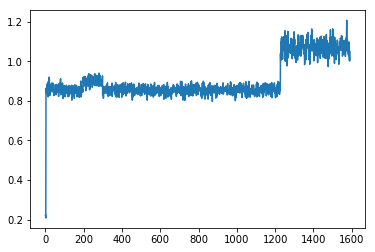

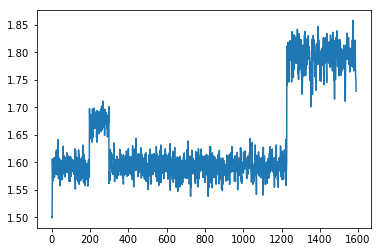

0.666666666667
[[[ 1.86516714  1.48265481]
  [ 1.83199668  1.68821418]
  [ 1.84623349  1.69914031]
  [ 1.85000467  1.69253755]
  [ 1.3964293   1.44612408]
  [ 0.920771    1.19581473]
  [ 0.47501174  0.96461326]
  [ 0.50502157  0.97840327]
  [ 0.48879573  0.97262841]
  [ 0.490392    0.97324145]]]


KeyboardInterrupt: 

In [ ]:
slen=24
w = np.array([delta**i for i in range(slen+2)]).reshape((-1,1))
for epoch in range(1000000):
    env_pool = [env(agresp, agupd) for _ in range(60)]
    batched_history = [envi() for envi in env_pool]
    
    for t in range(slen):
        batched_resp = agresp(batched_history)
        for i, envi in enumerate(env_pool):
            envi.roll(batched_resp[i])
        
        batched_history = [envi() for envi in env_pool]
        batched_rewards = [envi.ag.rewards for envi in env_pool]
        batched_actions = [envi.ag.actions for envi in env_pool]
        
    for _ in range(1):
        if random.random() < 0.5:
            i = 0
        else:
            i = 1
        agupd[i](batched_history, batched_rewards, batched_actions, 0.001)
        
    rews += [np.mean(batched_rewards)]
    drews += [np.mean(np.matmul(np.array(batched_rewards), w))*(1-delta)]
    if epoch % 10 == 0:
            recent = ag.q.eval({ag.var : np.array([[[1.,0.,0.,0.]]*4 + [[0,1,0,0]] + [[0,0,1,0]] + [[0,0,0,1]]*2 + [[0,1,0,0]]*2], dtype='float32')})*(1-delta)
    if epoch % 10 == 0:
        clear_output()
        plt.plot(rews, label='rews')
        plt.show()
        plt.plot(drews, label='drews')
        plt.show()
        print(np.mean(np.array(batched_rewards)[:,3] == 2))
        print(recent)

In [21]:
action_encoder([0,1])

[0.0, 0.0, 1.0, 0.0]

In [22]:
action_encoder([0,0])

[1.0, 0.0, 0.0, 0.0]

In [23]:
ag.q.eval({ag.var : np.array([[[1.,0.,0.,0.]]*4 + [[0,1,0,0]] + [[0,0,1,0]] + [[0,0,0,1]]*2 + [[0,1,0,0]]*2], dtype='float32')})*(1-delta)

array([[[ 1.86222684,  1.47555971],
        [ 1.81071961,  1.66799259],
        [ 1.80447698,  1.6658839 ],
        [ 1.7948401 ,  1.65159249],
        [ 1.26335287,  1.36889219],
        [ 0.76735848,  1.11218083],
        [ 0.43078461,  0.93730223],
        [ 0.46924359,  0.95395523],
        [ 0.45982745,  0.95110661],
        [ 0.46485522,  0.95351005]]], dtype=float32)

In [24]:
ag.q.eval({ag.var : np.array([[[1.,0.,0.,0.]]*30], dtype='float32')})*(1-delta)

array([[[ 1.86222684,  1.47555971],
        [ 1.81071961,  1.66799259],
        [ 1.80447698,  1.6658839 ],
        [ 1.7948401 ,  1.65159249],
        [ 1.79555011,  1.64638424],
        [ 1.79701447,  1.64438224],
        [ 1.79838657,  1.6437515 ],
        [ 1.79805517,  1.64306867],
        [ 1.79609478,  1.64196777],
        [ 1.79355168,  1.64076626],
        [ 1.79127336,  1.6397779 ],
        [ 1.78961706,  1.63911617],
        [ 1.78862047,  1.63876486],
        [ 1.7881763 ,  1.63865674],
        [ 1.78813076,  1.63871408],
        [ 1.78833747,  1.63886726],
        [ 1.78867722,  1.63906229],
        [ 1.78906572,  1.63926435],
        [ 1.78945124,  1.63945317],
        [ 1.78980577,  1.6396184 ],
        [ 1.79011893,  1.63975906],
        [ 1.79038882,  1.6398766 ],
        [ 1.79062057,  1.63997471],
        [ 1.79081917,  1.64005768],
        [ 1.79099226,  1.64012873],
        [ 1.79114473,  1.64019108],
        [ 1.79128182,  1.64024711],
        [ 1.79140592,  1.640